In [1]:
import cv2
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from utils import *
import os

from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import lsqr
from scipy.signal import correlate2d
from scipy.misc import imresize

In [2]:
def plot_no_frame(img, path=None, title=None, cmap=None):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    dpi = fig.get_dpi()
    fig.set_size_inches(img.shape[1]/float(dpi), img.shape[0]/float(dpi))

    if cmap is not None:
        ax.imshow(img, cmap=cmap)
    else:
        ax.imshow(img)
        
    if path is not None:
        fig.savefig(path)
        
    return fig

<IPython.core.display.Javascript object>


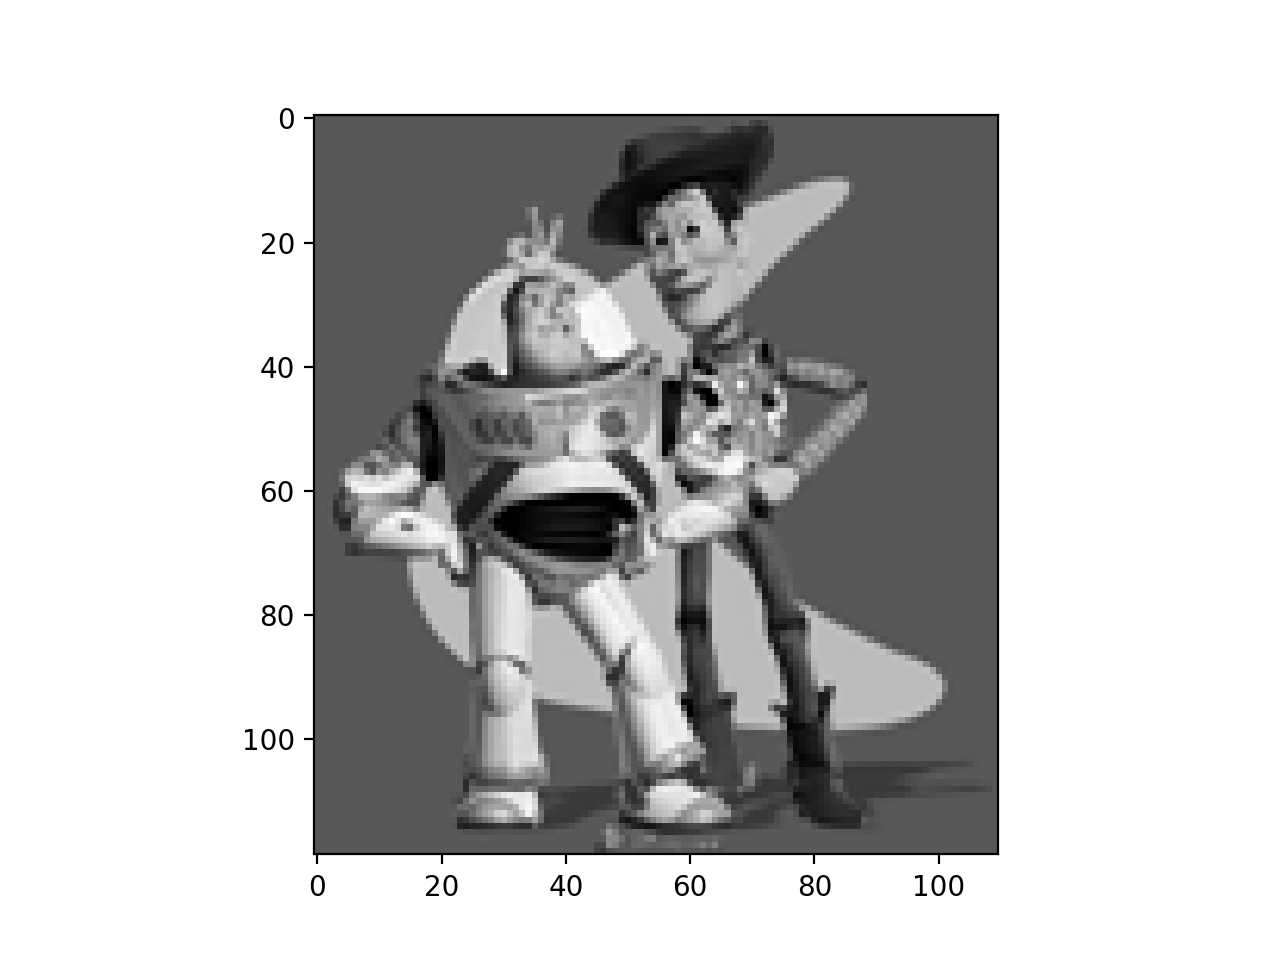

In [3]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY)
plt.imshow(toy_img, cmap='gray')

## Part 1 Toy Problem (20 pts)

In [4]:
def toy_reconstruct(toy_img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    im_h, im_w = toy_img.shape
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    
    A = np.zeros((im_h*im_w*2 + 1 - im_h - im_w, im_h*im_w))
    b = np.zeros( im_h*im_w*2 + 1 - im_h - im_w)
    
    toy_img_f = toy_img.astype(np.float32)
    
    e = 0
    for h in range(im_h):
        for w in range(im_w):
            if h+1 < im_h:
                A[e][im2var[h+1][w]] = 1
                A[e][im2var[h][w]] = -1
                b[e] = toy_img_f[h+1][w] - toy_img_f[h][w]
                e += 1
                
            if w+1 < im_w:
                A[e][im2var[h][w+1]] = 1
                A[e][im2var[h][w]] = -1
                b[e] = toy_img_f[h][w+1] - toy_img_f[h][w]
                e += 1
                
    A[e][im2var[0][0]] = 1
    b[e] = toy_img_f[0][0]
    
    v = np.linalg.solve(A.T.dot(A), A.T.dot(b))
    v = np.reshape(v, (im_w, im_h)).T
    v[v < 0] = 0
    v[v > 255] = 255
    v = v.astype(np.uint8)
    
    return v

In [ ]:
im_out = toy_reconstruct(toy_img)

In [ ]:
plt.imshow(im_out, cmap="gray")
print("Error is: ", np.sqrt(((im_out - toy_img)**2).sum()))

# Preparation

<IPython.core.display.Javascript object>


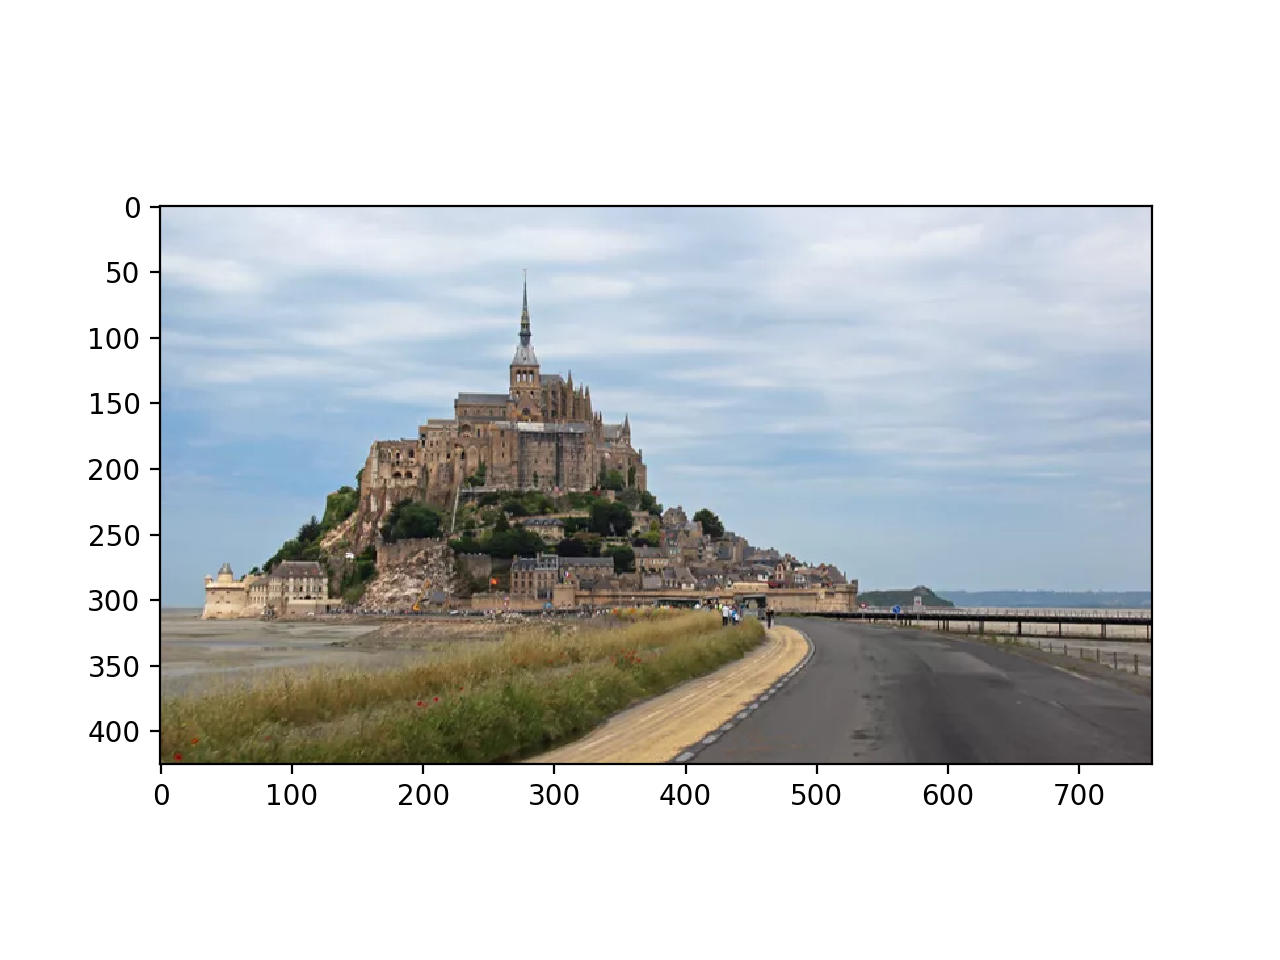

In [5]:
# Feel free to change image
background_img = cv2.cvtColor(cv2.imread('samples/castle.webp'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


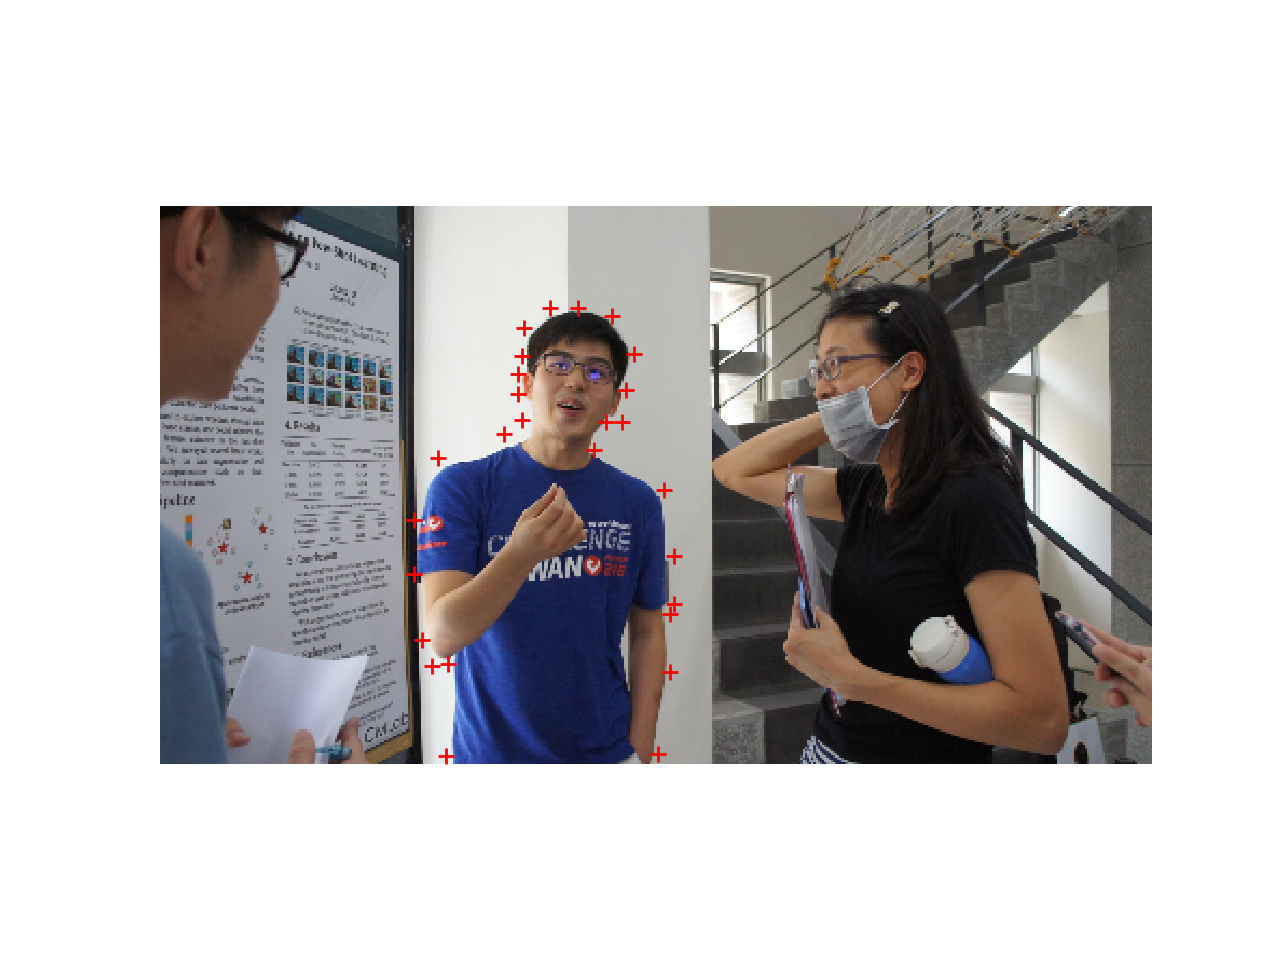

In [6]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread('samples/me.jpg'), cv2.COLOR_BGR2RGB)#.astype('double') / 255.0 
object_img = cv2.resize(object_img, None, fx=0.25, fy=0.25).astype('double') / 255.0 
import matplotlib.pyplot as plt
mask_coords = specify_mask(object_img)

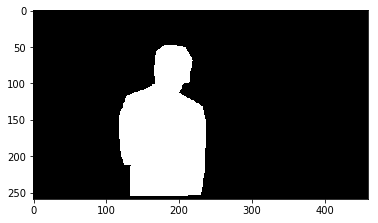

In [7]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


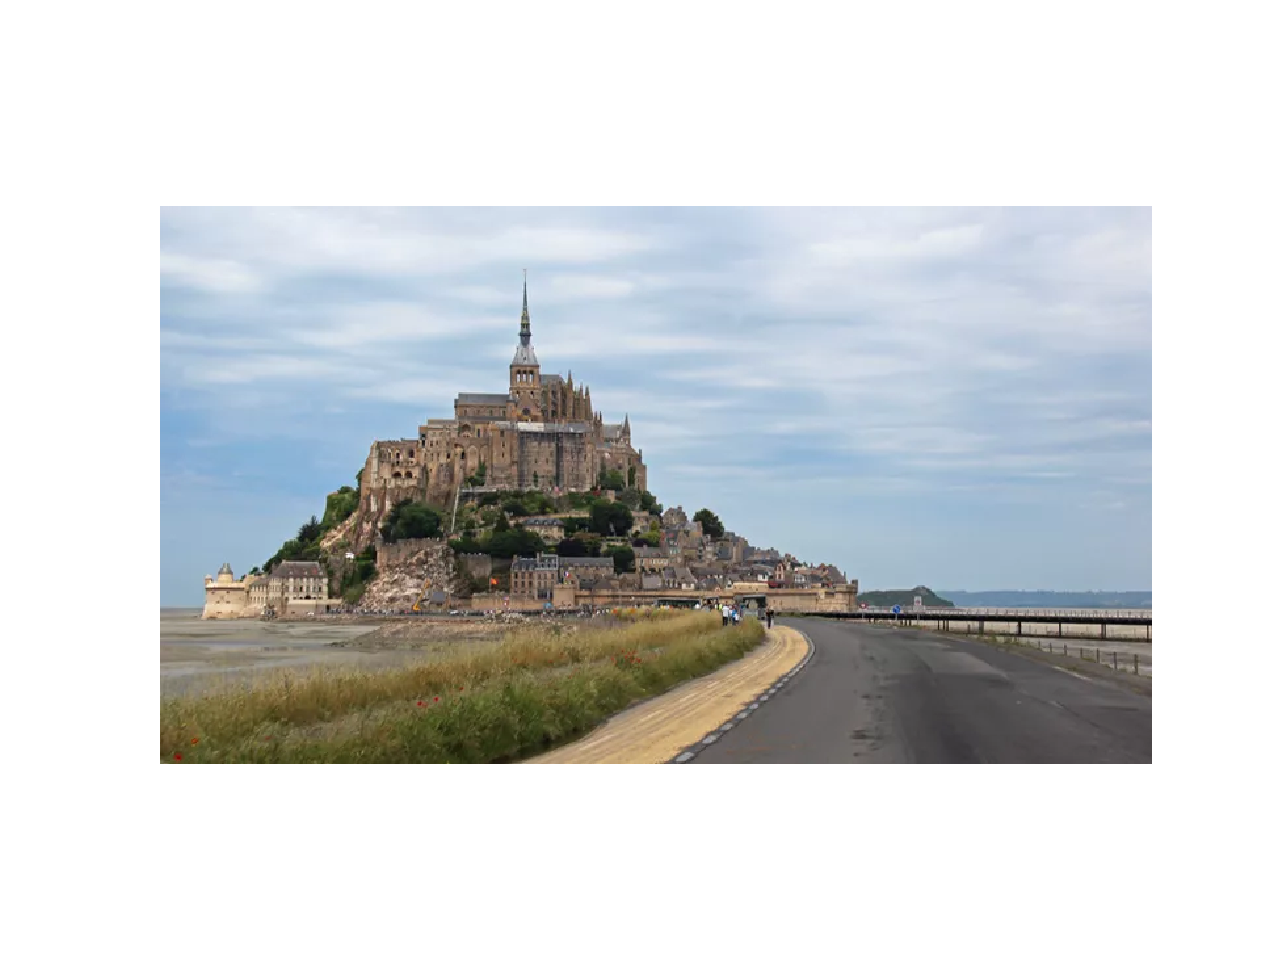

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

<IPython.core.display.Javascript object>


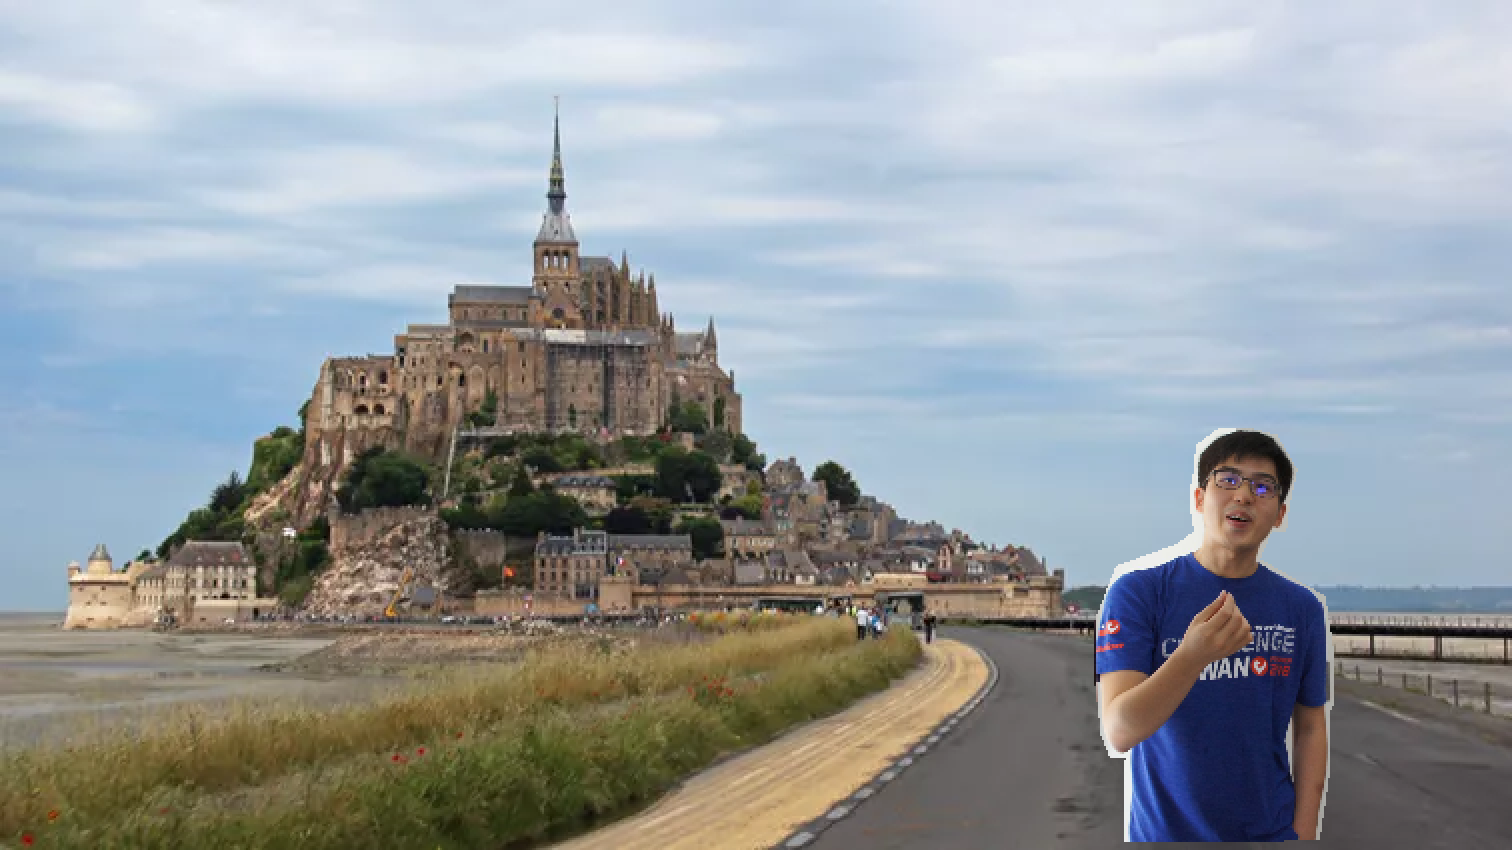

<IPython.core.display.Javascript object>


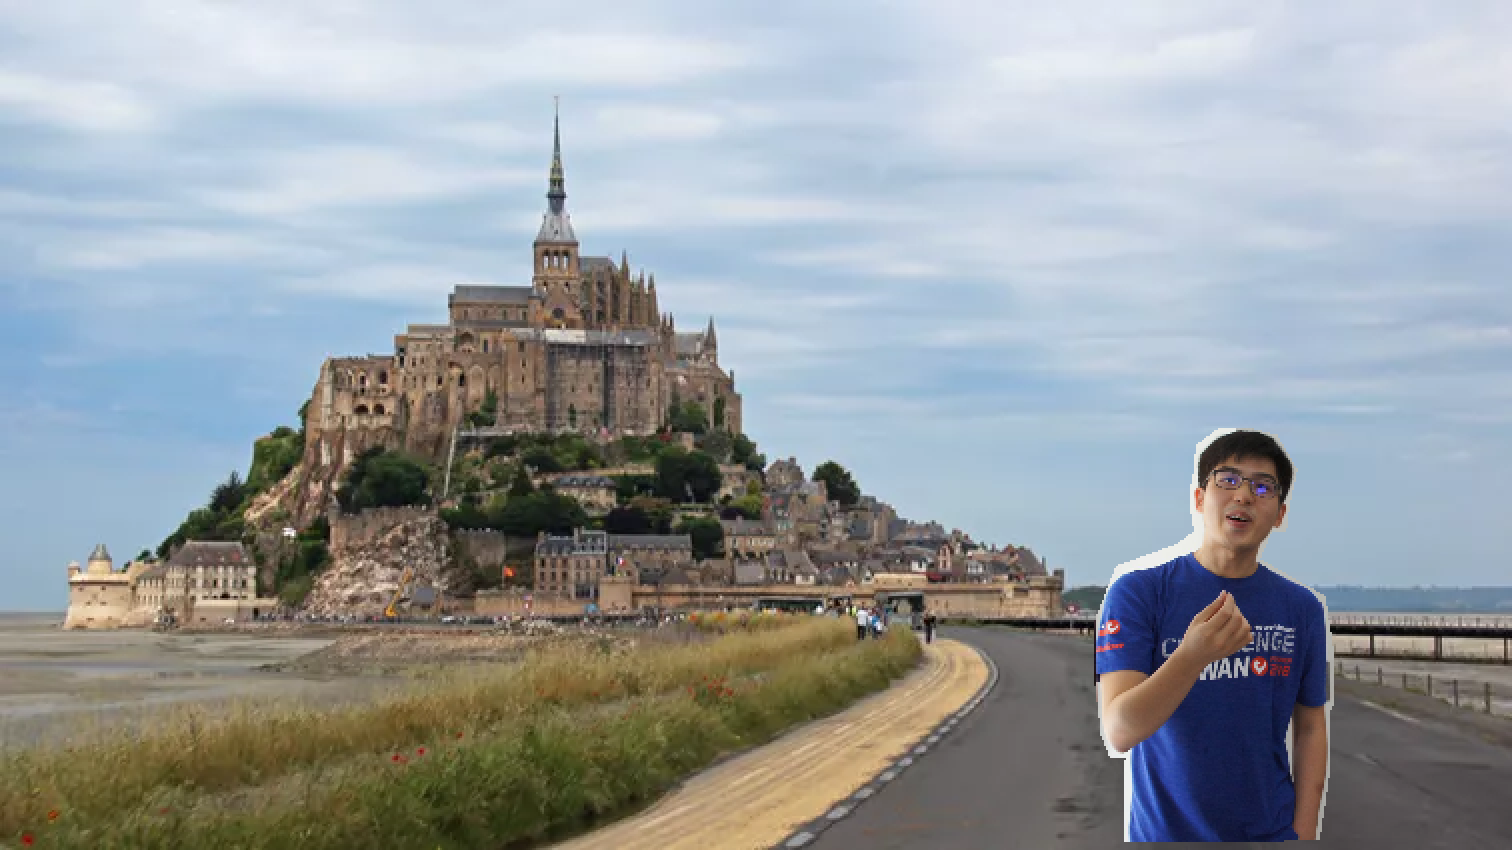

In [9]:
import matplotlib.pyplot as plt
cropped_object, object_mask, fused = align_source(object_img, mask, background_img, bottom_center, ret_img=True)

plot_no_frame(fused, path='results/me_at_castle_paste.png')

## Part 2 Poisson Blending (50 pts)

In [10]:
def add_constraint(A, b, im2var, pos_pt, neg_pt, val, e):
    pos_h, pos_w = pos_pt
    
    if neg_pt is not None:
        neg_h, neg_w = neg_pt
        A[e, im2var[neg_h, neg_w]] = -1
    
    A[e, im2var[pos_h, pos_w]] = 1
    b[e] = val
    return e + 1

def get_neighbors(h, w, object_mask, im_h, im_w):
    src_pixels, tgt_pixels = [], []
    if h-1 >= 0:
        if object_mask[h-1][w]:
            src_pixels.append((h-1, w))
        else:
            tgt_pixels.append((h-1, w))
            
    if h+1 < im_h:
        if object_mask[h+1][w]:
            src_pixels.append((h+1, w))
        else:
            tgt_pixels.append((h+1, w))
            
    if w+1 < im_w:
        if object_mask[h][w+1]:
            src_pixels.append((h, w+1))
        else:
            tgt_pixels.append((h, w+1))
            
    if w-1 >= 0:
        if object_mask[h][w-1]:
            src_pixels.append((h, w-1))
        else:
            tgt_pixels.append((h, w-1))
            
    return src_pixels, tgt_pixels

In [11]:
def poisson_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """

    im_h, im_w, im_c = background_img.shape
    
    blended = np.zeros_like(background_img)
    num_px = np.sum(object_mask)
    
    # Create pixel no. mapping
    px_id = 0
    im2var = np.zeros_like(background_img, dtype=np.uint32)
    for h in range(im_h):
        for w in range(im_w):
            if not object_mask[h, w]:
                continue
            im2var[h, w] = px_id
            px_id += 1
            
    
    for c in range(im_c):
        e = 0
        A = lil_matrix((num_px * 4, num_px))
        b = np.zeros(num_px * 4)
        
        for h in range(im_h):
            for w in range(im_w):
                if object_mask[h, w]:
                    src_pixels, tgt_pixels = get_neighbors(h, w, object_mask, im_h, im_w)
                    for pt in src_pixels:
                        pt_h, pt_w = pt
                        e = add_constraint(A, b, im2var, (h, w), (pt_h, pt_w), 
                                cropped_object[h, w, c] - cropped_object[pt_h, pt_w, c], e)
                    
                    for pt in tgt_pixels:
                        pt_h, pt_w = pt
                        e = add_constraint(A, b, im2var, (h, w), None, \
                                cropped_object[h, w, c] - cropped_object[pt_h, pt_w, c] + background_img[pt_h, pt_w, c], e)
                    
        A = A[:e]; b = b[:e]
        A = A.tocsr()
        
        v = lsqr(A, b)[0]
        v[v < 0] = 0
        v[v > 1] = 1
        
        v_cnt = 0
        for h in range(im_h):
            for w in range(im_w):
                if object_mask[h, w]:
                    blended[h, w, c] = v[v_cnt]
                    v_cnt += 1
                    
    blended[object_mask == 0] = background_img[object_mask == 0]
    blended *= 255
    return blended.astype(np.uint8)

In [12]:
im_blend = poisson_blend(cropped_object, object_mask, background_img)

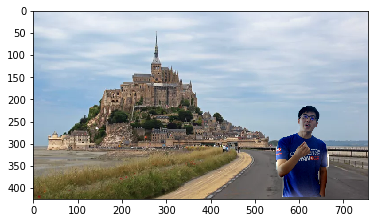

In [13]:
# if im_blend:

%matplotlib inline
import matplotlib.pyplot as plt
# plot_no_frame(im_blend, path="results/shoot_lion.png")
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [20]:
def mix_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    im_h, im_w, im_c = background_img.shape
    
    blended = np.zeros_like(background_img)
    num_px = np.sum(object_mask)
    
    # Create pixel no. mapping
    px_id = 0
    im2var = np.zeros_like(background_img, dtype=np.uint32)
    for h in range(im_h):
        for w in range(im_w):
            if not object_mask[h, w]:
                continue
            im2var[h, w] = px_id
            px_id += 1
            
    
    for c in range(im_c):
        e = 0
        A = lil_matrix((num_px * 4, num_px))
        b = np.zeros(num_px * 4)
        
        for h in range(im_h):
            for w in range(im_w):
                if object_mask[h, w]:
                    src_pixels, tgt_pixels = get_neighbors(h, w, object_mask, im_h, im_w)
                    for pt in src_pixels:
                        pt_h, pt_w = pt
                        
                        source_abs = abs(cropped_object[h, w, c] - cropped_object[pt_h, pt_w, c])
                        target_abs = abs(background_img[h, w, c] - background_img[pt_h, pt_w, c])
                        val = cropped_object[h, w, c] - cropped_object[pt_h, pt_w, c] \
                              if source_abs > target_abs else background_img[h, w, c] - background_img[pt_h, pt_w, c]
                        
                        e = add_constraint(A, b, im2var, (h, w), (pt_h, pt_w), val, e)
                    
                    for pt in tgt_pixels:
                        pt_h, pt_w = pt
                        
                        source_abs = abs(cropped_object[h, w, c] - cropped_object[pt_h, pt_w, c])
                        target_abs = abs(background_img[h, w, c] - background_img[pt_h, pt_w, c])
                        val = cropped_object[h, w, c] - cropped_object[pt_h, pt_w, c] \
                              if source_abs > target_abs else background_img[h, w, c] - background_img[pt_h, pt_w, c]
                            
                        e = add_constraint(A, b, im2var, (h, w), None, val + background_img[pt_h, pt_w, c], e)
                    
        A = A[:e]; b = b[:e]
        A = A.tocsr()
        
        v = lsqr(A, b)[0]
        v[v < 0] = 0
        v[v > 1] = 1
        
        v_cnt = 0
        for h in range(im_h):
            for w in range(im_w):
                if object_mask[h, w]:
                    blended[h, w, c] = v[v_cnt]
                    v_cnt += 1
                    
    blended[object_mask == 0] = background_img[object_mask == 0]
    blended *= 255
    return blended.astype(np.uint8)

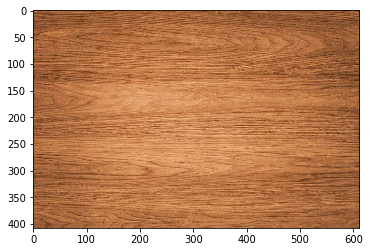

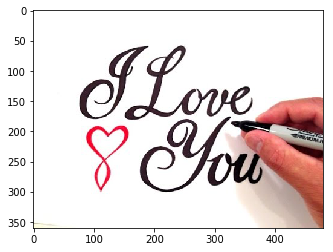

In [21]:
background_img = cv2.cvtColor(cv2.imread('samples/wood.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(background_img)
plt.show()

object_img = cv2.cvtColor(cv2.imread('samples/hand_writing.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


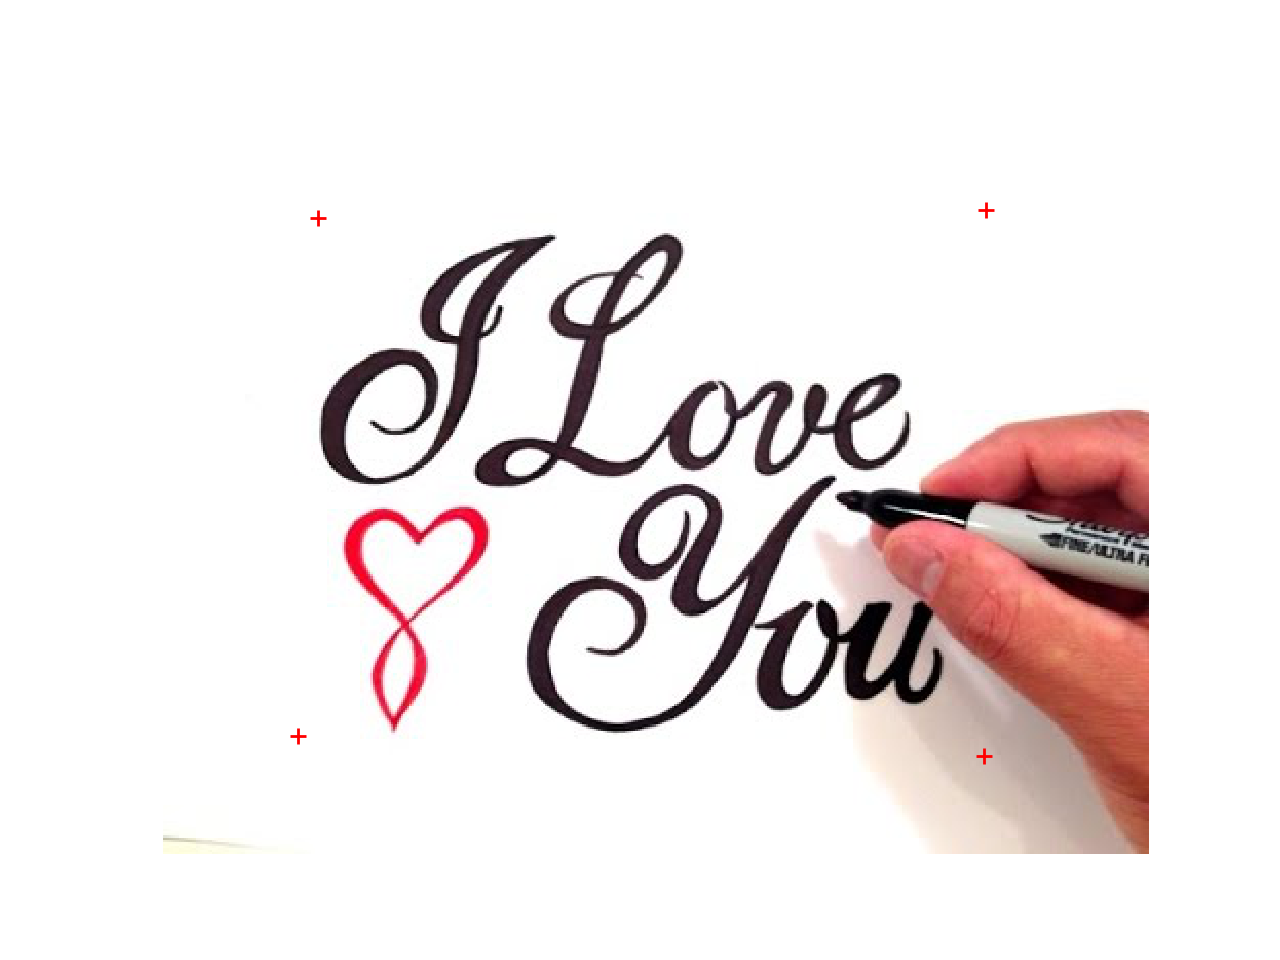

In [23]:
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

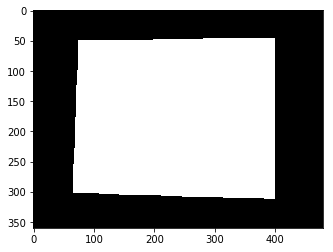

In [24]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


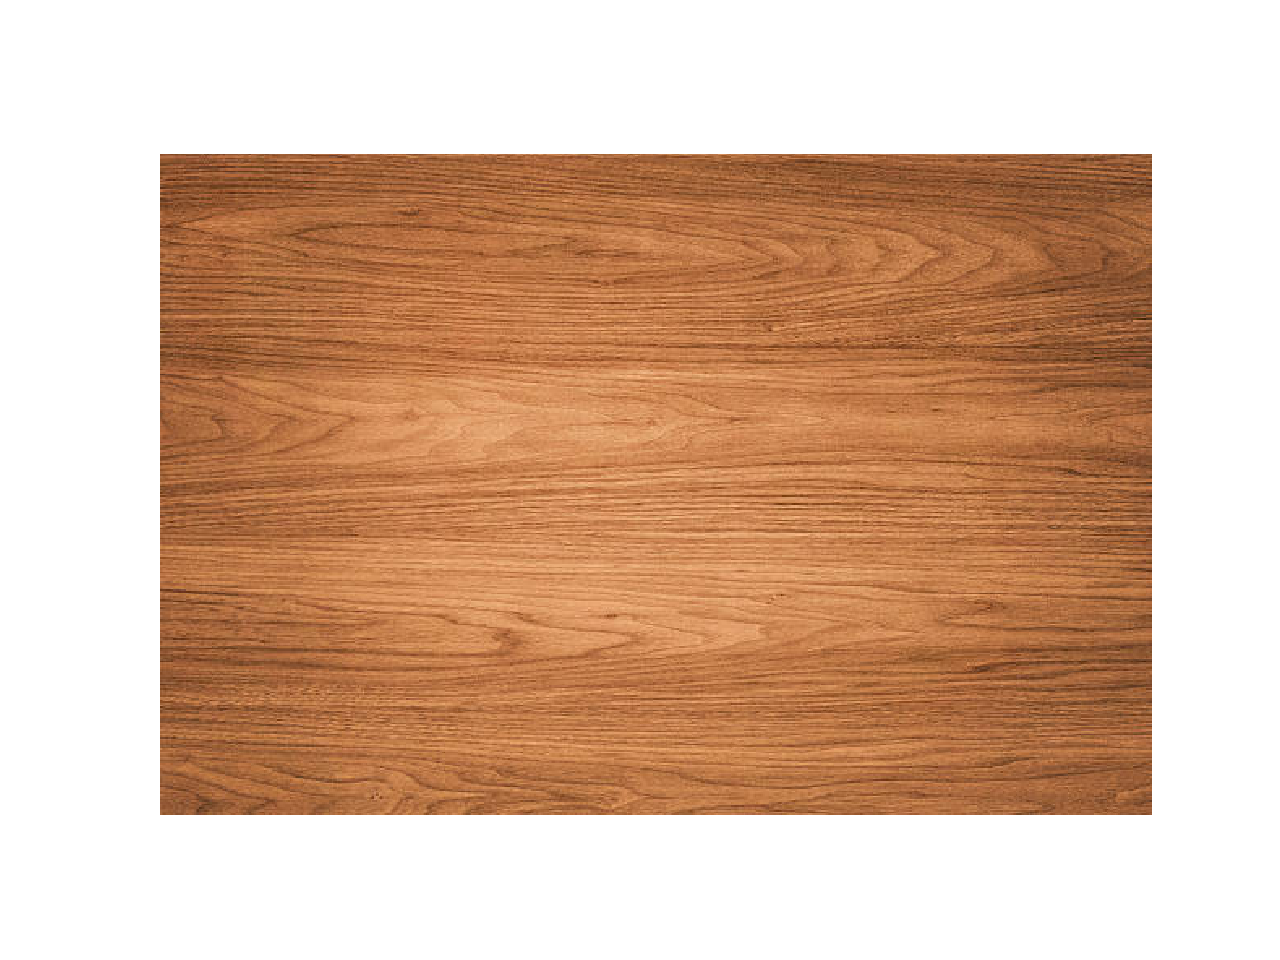

In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)

In [27]:
im_mix = mix_blend(cropped_object, object_mask, background_img)

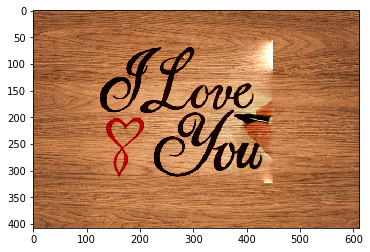

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot_no_frame(im_mix, "results/writing_on_wood.png")
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [29]:
def color2gray(img):
    im_h, im_w, im_c = img.shape
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    img = img.astype('double') / 255.0
    gray = gray.astype('double') / 255.0
    
    gradients = np.gradient(img)
    norm = np.sqrt(gradients[1] ** 2 + gradients[2] ** 2)
    norm = np.mean(norm, axis=-1)
    
    A = lil_matrix((im_h * im_w * 5, im_h * im_w))
    b = np.zeros(im_h * im_w * 5)
    e = 0
    weight = 20
    
    object_mask = np.ones_like(gray, dtype=bool)
    for h in range(im_h):
        for w in range(im_w):
            neighbors, _ = get_neighbors(h, w, object_mask, im_h, im_w)
            
            for pt in neighbors:
                pt_h, pt_w = pt
                
                norm_abs = abs(norm[h, w] - norm[pt_h, pt_w])
                gray_abs = abs(gray[h, w] - gray[pt_h, pt_w])
                val = weight * norm[h, w] - norm[pt_h, pt_w] \
                      if norm_abs > gray_abs else gray[h, w] - gray[pt_h, pt_w]
                
                e = add_constraint(A, b, im2var, (h, w), (pt_h, pt_w), val, e)
            
            e = add_constraint(A, b, im2var, (h, w), None, gray[h, w], e)
    
    A = A[:e]; b = b[:e]
    A = A.tocsr()

    v = lsqr(A, b)[0]
    v = np.reshape(v, (im_w, im_h)).T
    v[v < 0] = 0
    v[v > 1] = 1
    
    return (v * 255).astype(np.uint8)

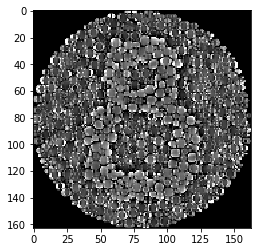

In [30]:
img = cv2.cvtColor(cv2.imread('samples/colorBlind8.png'), cv2.COLOR_BGR2RGB) 

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plot_no_frame(gray, "results/gray_8.png", cmap="gray")
plt.imshow(gray, cmap='gray')

convert = color2gray(img)
# plot_no_frame(convert, "results/8.png", cmap="gray")
plt.imshow(convert, cmap='gray')

## Laplacian pyramid blending (20 pts)

In [15]:
def laplacian_pyramid(im, freq=10, level=3):
    low_pass = gaussian_kernel(freq, 3 * freq)
    
    lap_pyr = []

    im_cur = im
    for l in range(level):
        tmp_lap = np.zeros_like(im_cur)
        tmp_im = np.zeros_like(im_cur[::2, ::2])
        
        for c in range(im_cur.shape[-1]):
            im_blurred = correlate2d(im_cur[:,:,c], low_pass, mode='same')

            im_laplacian = im_cur[:,:,c] - im_blurred
            tmp_lap[:,:,c] = im_laplacian
            
            im_subsampled = im_blurred[::2, ::2]
            tmp_im[:,:,c] = im_subsampled
            
        lap_pyr.append(tmp_lap)
        im_cur = tmp_im
        
    return lap_pyr

In [18]:
def upsample(img):
    return cv2.resize(img, None, fx=2, fy=2)

def laplacian_blend(cropped_object, object_mask, background_img):
    obj_pyr = laplacian_pyramid(cropped_object)
    bimg_pyr = laplacian_pyramid(background_img)
    mask_pyr = laplacian_pyramid(object_mask.astype(np.float32)[:, :, np.newaxis].repeat(3, axis=-1))
    
    imgs = []
    for i in range(len(obj_pyr)-1, -1, -1):
        obj, bimg, mask = obj_pyr[i], bimg_pyr[i], mask_pyr[i]
        
        img = obj * mask + bimg * (1 - mask)
        imgs.append(img)

    img = imgs[0]
    for i in range(1, len(imgs)):
        img = upsample(img)
        img = img[:imgs[i].shape[0], :imgs[i].shape[1], :] + imgs[i]
        
    for c in range(img.shape[-1]):
        img[:, :, c] = (img[:, :, c] - np.min(img[:, :, c])) / (np.max(img[:, :, c]) - np.min(img[:, :, c]))
        
    return (img*255).astype(np.uint8)

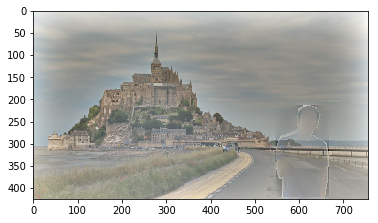

In [19]:
im_blend = laplacian_blend(cropped_object, object_mask, background_img)
plt.imshow(im_blend)

## More gradient domain processing (up to 20 pts)